In [0]:
filePath = "/content/drive/My Drive/Yelp Project/data/"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import pandas as pd

seed = 100

### Read Data and Check NaNs

In [4]:
dfPandas = pd.read_csv(filePath + "review_cleaned_withTrainTest.csv", index_col=0)
dfPandas.head()

,date,funny,useful,review_id,text,business_id,stars,cool,TrainTest
user_id,,,,,,,,,
BKcmc3Rj6L1EHeou_07IUw,2017-01-01 00:00:05,0,0,Mw89_xzMrWBPZJJkdGbnAA,Poor customer service. The only I gave this pl...,gBfPyzPRmeOaj3SdcIj0Rw,2.0,0,1
p4WztGxrJBrVWmt-xmY5Fg,2017-01-01 00:02:38,0,2,B55t0ioeFWWSlAQX4-0Q9Q,Came for brunch after hearing great reviews on...,xBgQ4T6mhS5VsmK9u6mBcg,4.0,0,1
8z-gipHHulR2HAeAE3pWpw,2017-01-01 00:03:16,0,2,OLeTF2dkoqeHo7qaErl2VA,We visited BWW to view the UFC 207 fight. This...,v8QuF4YX9Bb-qEtKLVPrmA,4.0,2,1
xRpAEg0M0azAPuKVg7WtgA,2017-01-01 00:04:18,4,1,GUsBYum0YCipOJ3HNyZ37g,Can't wait until I am 60 then I will get a car...,gjzQoi1AkRxYRl8-dFGGPQ,4.0,1,1
KCcGBudPGBLoviv5BbPiXQ,2017-01-01 00:05:19,0,0,-BlhsXgJFd8bd3_y71CkDw,I just love Nothing Bundt Cakes. They created ...,Ay7SK-nziJ7hnf6V_z6saA,5.0,0,1


In [5]:
dfPandas.shape

(392471, 9)

In [6]:
print("NaNs: \n", dfPandas.isnull().sum())
dfPandas.reset_index(drop=True, inplace=True)
dfPandas.loc[dfPandas.isnull().any(axis=1)]

NaNs: 
 date           0
funny          0
useful         0
review_id      0
text           0
business_id    0
stars          0
cool           0
TrainTest      0
dtype: int64


,date,funny,useful,review_id,text,business_id,stars,cool,TrainTest


### Text Preprocessing

##### CountVectorize + Tfidf

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_df=0.95, min_df=0.05)
count_vectorizer.fit(dfPandas['text'])

In [0]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(count_vectorizer.transform(dfPandas['text']))

In [0]:
tfidf = tfidf_transformer.transform(count_vectorizer.transform(dfPandas['text']))

### Store Results for further usage

In [0]:
import pickle

pickle.dump(count_vectorizer, open(filePath + 'countVectorizer.pkl', 'wb'))
pickle.dump(tfidf_transformer, open(filePath + 'tfidfTransformer.pkl', 'wb'))

In [0]:
import scipy
scipy.sparse.save_npz(filePath + 'textTransform.npz', tfidf)

### Loading Previous Text Preprocessing Results

In [0]:
import scipy.sparse as ss
tfidf = ss.load_npz(filePath + 'textTransform.npz')

In [10]:
import pickle
count_vectorizer = pickle.load(open(filePath + 'countVectorizer.pkl', 'rb'))
tfidf_transformer = pickle.load(open(filePath + 'tfidfTransformer.pkl', 'rb'))

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Explore Text Preprocessing Results

In [0]:
x = pd.DataFrame(count_vectorizer.fit_transform(dfPandas['text']).toarray())

Text(0.5, 0, 'Words')

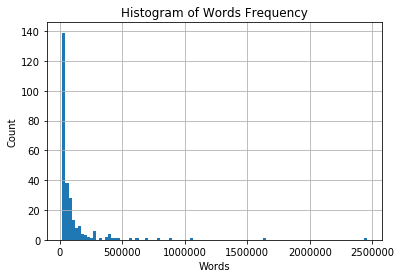

In [20]:
import matplotlib.pyplot as plt
x.sum(axis=0).hist(bins=100)
plt.title('Histogram of Words Frequency')
plt.ylabel('Count')
plt.xlabel('Words')

In [25]:
import numpy as np
x_sort = x.sum(axis=0).sort_values()
print("Top 100 Frequency Words in Reviews")
np.array(count_vectorizer.get_feature_names())[x_sort.iloc[:100].index]

Top 100 Frequency Words in Reviews


array(['everyone', 'enjoy', 'once', 'decided', 'tasted', 'away', 'cooked',
       'need', 'ok', 'each', 'same', 'should', 'fun', 'home', 'probably',
       'things', 'loved', 'looking', 'huge', 'quite', 'prices', 'full',
       'feel', 'friend', 'nothing', 'enjoyed', 'however', 'special',
       'into', 'clean', 'large', 'friends', 'dishes', 'inside', 'options',
       'atmosphere', 'places', 'stars', 'excellent', 'spicy', 'enough',
       'top', 'coming', 'beef', 'awesome', 'wanted', 'find', 'visit',
       'check', '10', 'last', 'tasty', 'perfect', 'thing', 'where',
       'hour', 'dish', 'big', 'quality', 'asked', 'busy', 'cream', 'spot',
       'overall', 'ever', 'bad', 'am', 'vegas', 'being', 'different',
       'another', 'fried', 'long', 'something', 'every', 'drink', 'worth',
       'flavor', 'meat', 'took', 'sweet', 'hot', 'though', 'minutes',
       'give', 'now', 'her', 'most', 'fries', 'next', 'happy', 'price',
       'taste', 'rice', 'favorite', 'new', 'many', 'll', 'both'

### Split Train / Test Set

In [26]:
dfPandas['TrainTest'].value_counts()

1    343827
0     48644
Name: TrainTest, dtype: int64

In [0]:
train_X = tfidf.toarray()[dfPandas['TrainTest'] == 1, :]
train_y = dfPandas.loc[dfPandas['TrainTest'] == 1]['stars']

test_X = tfidf.toarray()[dfPandas['TrainTest'] == 0, :]
test_y = dfPandas.loc[dfPandas['TrainTest'] == 0]['stars']

In [28]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((343827, 269), (343827,), (48644, 269), (48644,))

### Modeling On Text against Ratings

In [0]:
!pip install scikit-learn==0.22.0
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

##### Logistic Regression

In [0]:
lr = LogisticRegression()
lr.fit(train_X, train_y)

In [0]:
pred_train_y = lr.predict(train_X)
pred_y = lr.predict(test_X)

In [0]:
accuracy_score(test_y, pred_y), mean_squared_error(test_y, pred_y)

(0.6115656607186909, 1.10145136090782)

In [0]:
pred_train_y

array([1., 4., 3., ..., 5., 5., 2.])

In [0]:
pd.DataFrame(
    pred_train_y, 
    index=train_y.index, 
    columns=['stars']
).to_csv(
    filePath + 'textLR_trainPredict.csv', index=False
)

pd.DataFrame(
    pred_y, 
    index=test_y.index, 
    columns=['stars']
).to_csv(
    filePath + 'textLR_testPredict.csv', index=False
  )

In [0]:
import pickle
pickle.dump(lr, open(filePath + 'text_lr.pkl', 'wb'))

##### Stack Ensemble (Decision Tree + Multinomial Naive Bayes + Ridge Classifier)

In [0]:
estimators = [
  ('dt', DecisionTreeClassifier(min_samples_leaf=0.001, random_state=seed)),
  ('nb', MultinomialNB())
]
clf = StackingClassifier(
  estimators=estimators, final_estimator=RidgeClassifier(), passthrough=True
)

In [0]:
%timeit
clf.fit(train_X, train_y)
ensemble_pred = clf.predict(test_X)

In [0]:
ensemble_pred_train_y = clf.predict(train_X)

In [0]:
accuracy_score(test_y, ensemble_pred), mean_squared_error(test_y, ensemble_pred)

(0.603856590740893, 1.2511101060768028)

In [0]:
pd.DataFrame(
    ensemble_pred_train_y, 
    index=train_y.index, 
    columns=['stars']
).to_csv(
    filePath + 'textEnsemble_trainPredict.csv', index=False
)

pd.DataFrame(
    ensemble_pred, 
    index=test_y.index, 
    columns=['stars']
).to_csv(
    filePath + 'textEnsemble_testPredict.csv', index=False
  )